In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm, preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from pathlib import Path
from skopt.space import Real, Categorical, Integer


# Inputs|

In [32]:
input_path = "../data/gold/"
output_path = "../data/platinum/"

Path(output_path).mkdir(parents=True, exist_ok=True)

all_data = pd.read_parquet(input_path + "anomaly_features.parquet", engine='pyarrow')

train_df, test_df = train_test_split(all_data, test_size=0.10, random_state=42, stratify=all_data['anomaly'])

# Verify the results
print(f"Total rows: {len(all_data)}")
print(f"Training rows: {len(train_df)} (90%)")
print(f"Testing rows: {len(test_df)} (10%)")

df_anomaly = train_df[train_df['anomaly'] == 1] # The 40,000 anomalies
df_normal = train_df[train_df['anomaly'] == 0]  # The 1.7M normal cases

# 2. Calculate the required number of normal samples for a 70/30 split
# If 40k is 30%, then X is 70% -> (40,000 / 0.3) * 0.7
num_normal_needed = int((len(df_anomaly) / 0.3) * 0.7)

# 3. Downsample Class B (Normal)
df_normal_downsampled = df_normal.sample(n=num_normal_needed, random_state=42)

# 4. Combine them into your new training set
df_train_7030 = pd.concat([df_anomaly, df_normal_downsampled])

# 5. Shuffle the resulting dataframe
df_train_7030 = df_train_7030.sample(frac=1, random_state=42).reset_index(drop=True)

# Verification
print(f"New Training Set Size: {len(df_train_7030)}")
print(f"Class 1 (Anomaly): {len(df_anomaly)} ({len(df_anomaly)/len(df_train_7030):.1%})")
print(f"Class B (Normal): {len(df_normal_downsampled)} ({len(df_normal_downsampled)/len(df_train_7030):.1%})")

Total rows: 1749494
Training rows: 1574544 (90%)
Testing rows: 174950 (10%)
New Training Set Size: 111886
Class 1 (Anomaly): 33566 (30.0%)
Class B (Normal): 78320 (70.0%)


# Model 1

In [3]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('encoder', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,None
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [6]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

opt.fit(df_train_7030.drop(['anomaly','timestamp'], axis=1), df_train_7030['anomaly'])

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [9]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

test_df_2 = test_df.dropna(inplace=False) # Ensure no NaN values in the test set for evaluation
# 1. Ensure X_test is prepared (numeric only, no 'anomaly' or 'timestamp')
X_test_xgb = test_df_2.drop(['anomaly','timestamp'], axis=1)
y_test = test_df_2['anomaly']

# 2. Generate predictions (0 or 1)
y_pred_xgb = opt.predict(X_test_xgb)

# 3. Generate probabilities (needed for ROC AUC)
# predict_proba returns [prob_class_0, prob_class_1]. We want index 1.
y_probs_xgb = opt.predict_proba(X_test_xgb)[:, 1]

# --- RESULTS ---
print("--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

print(f"XGBoost Accuracy Score: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, y_probs_xgb):.4f}")

# 4. Optional: Quick view of the Confusion Matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_xgb))

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171015
           1       0.00      0.00      0.00      3728

    accuracy                           0.98    174743
   macro avg       0.49      0.50      0.49    174743
weighted avg       0.96      0.98      0.97    174743

XGBoost Accuracy Score: 0.9787
XGBoost ROC AUC Score: 0.8771

--- Confusion Matrix ---
[[171015      0]
 [  3728      0]]


c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

# Model 2

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# List of the problematic columns from your error message
cat_cols = ['building_month', 'building_hour', 'building_week_day_hour', 'primary_use']

xgb_train = df_train_7030.drop('timestamp', axis=1)
xgb_test = test_df

# Convert them to 'category' dtype
for col in cat_cols:
    xgb_train[col] = xgb_train[col].astype('category')
    xgb_test[col] = xgb_test[col].astype('category') # Don't forget the test set!

X = xgb_train.drop(['anomaly'], axis=1)
y = xgb_train['anomaly']

num_neg = (y == 0).sum()
num_pos = (y == 1).sum()
scale_weight = num_neg / num_pos

print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_weight, # From our previous calculation
    tree_method='hist',      
    enable_categorical=True, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 4. Fit the model
# On 100k rows, this should take anywhere from 10 to 60 seconds
xgb_model.fit(X, y)

print("Model Training Complete!")

Calculated scale_pos_weight: 2.33


c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Training Complete!


In [19]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

test_df_2 = xgb_test.dropna(inplace=False) # Ensure no NaN values in the test set for evaluation
# 1. Ensure X_test is prepared (numeric only, no 'anomaly' or 'timestamp')
X_test_xgb = test_df_2.drop(['anomaly','timestamp'], axis=1)
y_test = test_df_2['anomaly']

# 2. Generate predictions (0 or 1)
y_pred_xgb = xgb_model.predict(X_test_xgb)

# 3. Generate probabilities (needed for ROC AUC)
# predict_proba returns [prob_class_0, prob_class_1]. We want index 1.
y_probs_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

# --- RESULTS ---
print("--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

print(f"XGBoost Accuracy Score: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, y_probs_xgb):.4f}")

# 4. Optional: Quick view of the Confusion Matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoostError: [23:15:16] C:\actions-runner\_work\xgboost\xgboost\src\data\../data/cat_container.h:29: Found a category not in the training set for the 5th (0-based) column: `996_6_9`

# Model 3

In [25]:
#test_df
#df_train_7030
X_train = df_train_7030.drop(['anomaly','timestamp'], axis=1)
y_train = df_train_7030['anomaly']

X_test = test_df.drop(['anomaly','timestamp'], axis=1)
y_test = test_df['anomaly']

In [26]:
# !pip install category_encoders
from category_encoders import TargetEncoder
import xgboost as xgb

# 1. Identify categorical columns
cat_cols = ['building_month', 'building_hour', 'building_week_day_hour', 'primary_use']

# 2. Instantiate and Fit the Encoder
# 'smoothing' helps when a category only appears a few times
encoder = TargetEncoder(cols=cat_cols, smoothing=1.0)

# 3. Transform your data
# This converts the strings into 'anomaly probability' floats
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

num_neg = (y == 0).sum()
num_pos = (y == 1).sum()
scale_weight = num_neg / num_pos

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_weight, # From our previous calculation
    tree_method='hist',      
    enable_categorical=True, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 4. Fit the model
# On 100k rows, this should take anywhere from 10 to 60 seconds
xgb_model.fit(X_train_encoded, y_train)

print("Model Training Complete!")


c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [23:32:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Training Complete!


In [31]:
scale_weight

np.float64(2.3333134719656794)

In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Ensure X_test is prepared (numeric only, no 'anomaly' or 'timestamp')
X_test_xgb = X_test_encoded

# 2. Generate predictions (0 or 1)
y_pred_xgb = xgb_model.predict(X_test_xgb)

# 3. Generate probabilities (needed for ROC AUC)
# predict_proba returns [prob_class_0, prob_class_1]. We want index 1.
y_probs_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

# --- RESULTS ---
print("--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

print(f"XGBoost Accuracy Score: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, y_probs_xgb):.4f}")

# 4. Optional: Quick view of the Confusion Matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_xgb))

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    171220
           1       0.14      0.85      0.24      3730

    accuracy                           0.88    174950
   macro avg       0.57      0.87      0.59    174950
weighted avg       0.98      0.88      0.92    174950

XGBoost Accuracy Score: 0.8845
XGBoost ROC AUC Score: 0.9448

--- Confusion Matrix ---
[[151584  19636]
 [   566   3164]]


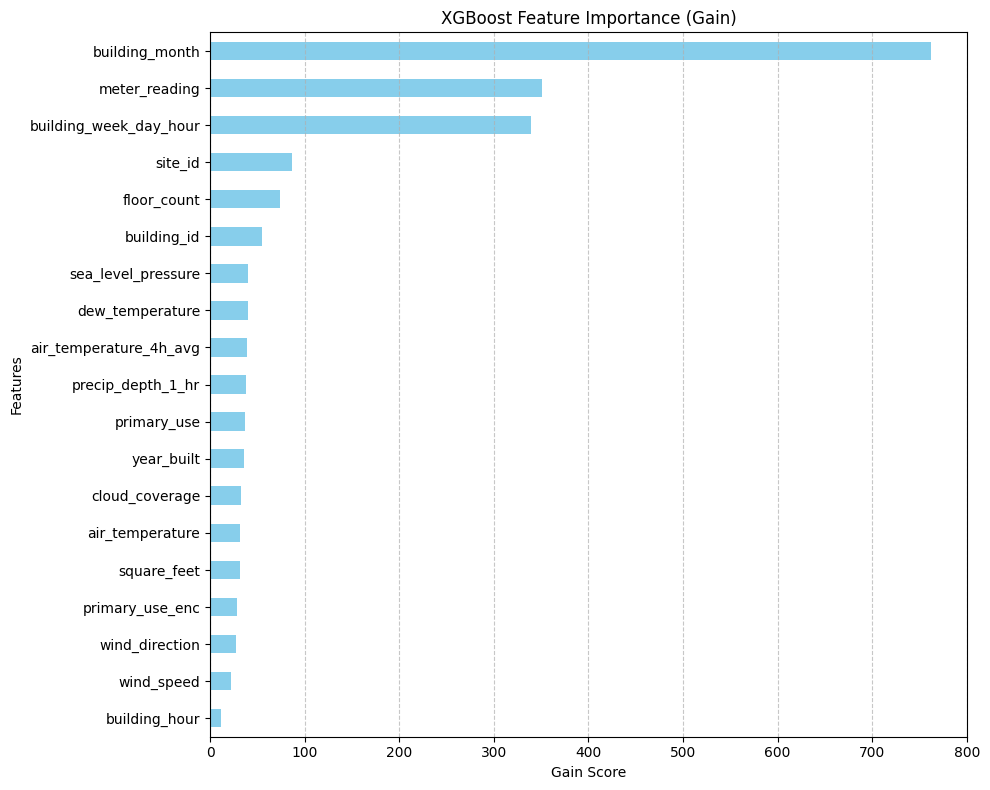

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get feature importance from XGBoost
# 'gain' is usually the most informative metric; it represents the average 
# improvement in accuracy brought by a feature.
importances = xgb_model.get_booster().get_score(importance_type='gain')

# 2. Convert to a sorted DataFrame for plotting
feat_importances = pd.Series(importances).sort_values(ascending=True)

# 3. Plot the results
plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh', color='skyblue')
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Gain Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

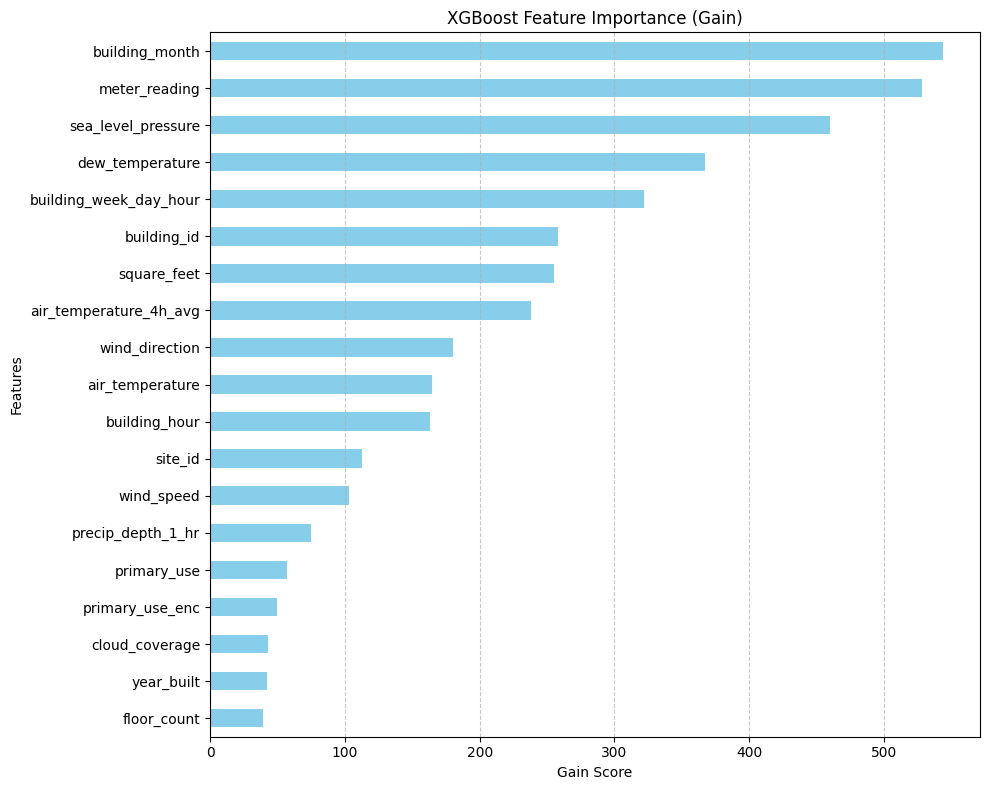

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get feature importance from XGBoost
# 'gain' is usually the most informative metric; it represents the average 
# improvement in accuracy brought by a feature.
importances = xgb_model.get_booster().get_score(importance_type='weight')

# 2. Convert to a sorted DataFrame for plotting
feat_importances = pd.Series(importances).sort_values(ascending=True)

# 3. Plot the results
plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh', color='skyblue')
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Gain Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()